# Analyzing frequency and power spectrum of significant cells. 

In [1]:
import sys
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("/home/gergely/code/sleep/base/")

from suite2p_class import Suite2p
from eeg_class import eegData
from behavior_class import behaviorData
import neuropil as nl

In [2]:
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

In [9]:
results = {}

for sima_folder in sima_folders:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    cells = s2p_data.cells()
    npil = s2p_data.npil()

    nrem_cells = cells[:, df["NREM"].values]
    awake_immobile_cells = cells[:, df["awake_immobile"].values]

    significant_cells = nl.statistics.significance_calc(
        nrem_cells, awake_immobile_cells
    )
    significant_cell_data = cells[significant_cells, :]
    nonsignificant_cell_data = cells[~significant_cells, :]

    mean_significant = np.mean(significant_cell_data, axis=0)
    mean_nonsignificant = np.mean(nonsignificant_cell_data, axis=0)

    nrem_sig_mean = pd.Series(mean_significant[df["NREM"].values])
    awake_sig_mean = pd.Series(mean_significant[df["awake_immobile"].values])
    nrem_nonsig_mean = pd.Series(mean_nonsignificant[df["NREM"].values])
    awake_nonsig_mean = pd.Series(mean_nonsignificant[df["awake_immobile"].values])

    nrem_sig_freq, nrem_sig_psd = nl.freq_calc(nrem_sig_mean, resolution=0.01)
    awake_sig_freq, awake_sig_psd = nl.freq_calc(awake_sig_mean, resolution=0.01)
    nrem_nonsig_freq, nrem_nonsig_psd = nl.freq_calc(nrem_nonsig_mean, resolution=0.01)
    awake_nonsig_freq, awake_nonsig_psd = nl.freq_calc(
        awake_nonsig_mean, resolution=0.01
    )

    sima_dict["awake_sig"] = {
        "freq": awake_sig_freq,
        "psd": awake_sig_psd,
    }

    sima_dict["nrem_sig"] = {
        "freq": nrem_sig_freq,
        "psd": nrem_sig_psd,
    }

    sima_dict["awake_nonsig"] = {
        "freq": awake_nonsig_freq,
        "psd": awake_nonsig_psd,
    }

    sima_dict["nrem_nonsig"] = {
        "freq": nrem_nonsig_freq,
        "psd": nrem_nonsig_psd,
    }

    results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima
/data2/ger

In [10]:
results_df = pd.DataFrame.from_dict(results)
results_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
awake_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."


In [11]:
# 1. Extract PSD arrays
psd_df = results_df.applymap(
    lambda d: d["psd"] if isinstance(d, dict) and "psd" in d else np.nan
)
psd_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"[4028.3525, 14021.676, 13766.118, 10639.618, 1...","[3033.9768, 8963.222, 7880.561, 4621.9946, 239...","[6060.9844, 22374.871, 27613.656, 22000.521, 1...","[7034.0913, 40284.152, 50131.227, 28614.389, 1...","[1772.0178, 7472.82, 7150.942, 5453.891, 4314....","[3882.711, 18796.926, 33444.656, 38747.164, 23...","[9413.007, 37634.54, 34300.953, 15469.587, 141...","[34099.33, 101710.26, 91502.44, 31259.732, 101...","[6069.3813, 20592.229, 20623.395, 18871.04, 85...","[17720.322, 78363.0, 63287.574, 32878.094, 206..."
nrem_sig,"[489511.62, 1054460.2, 232619.44, 117863.83, 2...","[1598.6028, 6596.7144, 7832.703, 5696.2246, 51...","[3400.2603, 15841.115, 17261.076, 12829.068, 7...","[11713.126, 59205.848, 60918.617, 40915.45, 38...","[970.4773, 4899.7305, 5730.2974, 3710.344, 272...","[5978.059, 20670.895, 19944.725, 16285.548, 14...","[10988.671, 44055.86, 67613.74, 76763.68, 5853...","[12874.072, 67142.12, 70003.875, 36928.79, 197...","[11495.693, 53135.63, 47209.82, 22267.076, 149...","[2941.9636, 13638.778, 18988.775, 16200.243, 1..."
awake_nonsig,"[3286.959, 12327.233, 17038.188, 16560.771, 11...","[4053.1558, 15217.776, 14897.117, 8642.004, 41...","[11202.49, 35060.098, 21299.996, 11497.856, 10...","[3133.5327, 29617.9, 42537.895, 31166.668, 178...","[2329.6067, 8280.614, 7142.9014, 5473.785, 435...","[4898.445, 13187.471, 9568.571, 9724.84, 10649...","[7911.282, 34085.25, 32919.617, 16358.1875, 14...","[22413.188, 64575.645, 62259.902, 23894.547, 8...","[1510.4536, 4617.974, 4194.528, 4273.4087, 348...","[30033.02, 123117.85, 115672.734, 46216.332, 2..."
nrem_nonsig,"[55947.043, 119583.36, 44504.664, 21081.992, 1...","[1543.2762, 6325.866, 6805.718, 4492.2705, 466...","[2518.384, 11908.225, 15705.997, 8689.462, 638...","[10354.917, 53133.4, 55366.984, 38287.59, 3695...","[847.31213, 4482.8467, 5380.234, 3625.9004, 25...","[3853.9158, 12755.715, 11425.913, 7477.8735, 7...","[8833.255, 37161.676, 61424.793, 71080.945, 53...","[9427.397, 48850.855, 52328.336, 29480.246, 16...","[1744.7684, 6036.048, 5599.25, 2965.459, 1229....","[1491.7742, 6489.726, 11038.178, 9507.284, 521..."


<Axes: title={'center': 'Non-significant cells'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency (dB/Hz)'>

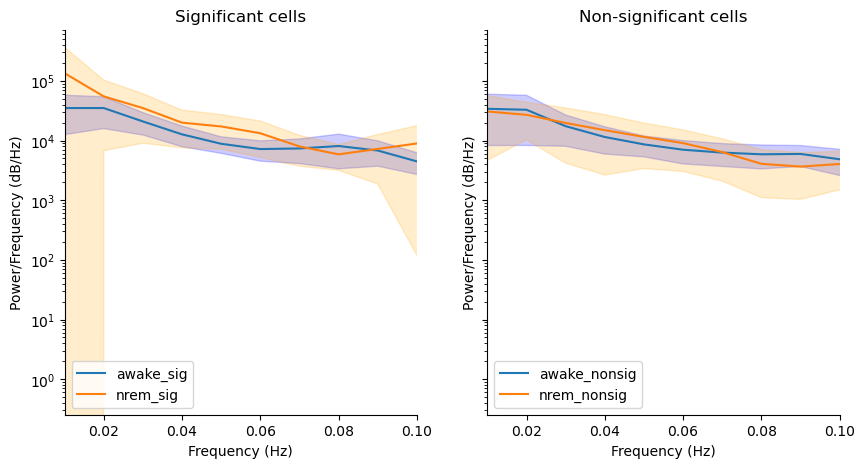

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

nl.spectral_density_plot(
    psd_df, ["awake_sig", "nrem_sig"], ax=ax[0], labels={"title": "Significant cells"}
)
nl.spectral_density_plot(
    psd_df,
    ["awake_nonsig", "nrem_nonsig"],
    ax=ax[1],
    labels={"title": "Non-significant cells"},
)

## Neuropil signal

In [15]:
npil_results = {}

for sima_folder in sima_folders:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    cells = s2p_data.cells()
    npil = s2p_data.npil()

    nrem_cells = cells[:, df["NREM"].values]
    awake_immobile_cells = cells[:, df["awake_immobile"].values]

    significant_cells = nl.statistics.significance_calc(
        nrem_cells, awake_immobile_cells
    )

    significant_npil = npil[significant_cells, :]
    nonsignificant_npil = npil[~significant_cells, :]

    mean_significant = np.mean(significant_npil, axis=0)
    mean_nonsignificant = np.mean(nonsignificant_npil, axis=0)

    nrem_sig_mean = pd.Series(mean_significant[df["NREM"].values])
    awake_sig_mean = pd.Series(mean_significant[df["awake_immobile"].values])
    nrem_nonsig_mean = pd.Series(mean_nonsignificant[df["NREM"].values])
    awake_nonsig_mean = pd.Series(mean_nonsignificant[df["awake_immobile"].values])

    nrem_sig_freq, nrem_sig_psd = nl.freq_calc(nrem_sig_mean, resolution=0.01)
    awake_sig_freq, awake_sig_psd = nl.freq_calc(awake_sig_mean, resolution=0.01)
    nrem_nonsig_freq, nrem_nonsig_psd = nl.freq_calc(nrem_nonsig_mean, resolution=0.01)
    awake_nonsig_freq, awake_nonsig_psd = nl.freq_calc(
        awake_nonsig_mean, resolution=0.01
    )

    sima_dict["awake_sig"] = {
        "freq": awake_sig_freq,
        "psd": awake_sig_psd,
    }

    sima_dict["nrem_sig"] = {
        "freq": nrem_sig_freq,
        "psd": nrem_sig_psd,
    }

    sima_dict["awake_nonsig"] = {
        "freq": awake_nonsig_freq,
        "psd": awake_nonsig_psd,
    }

    sima_dict["nrem_nonsig"] = {
        "freq": nrem_nonsig_freq,
        "psd": nrem_nonsig_psd,
    }

    npil_results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima
/data2/ger

In [16]:
npil_results_df = pd.DataFrame.from_dict(npil_results)
npil_results_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
awake_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."


In [17]:
# 1. Extract PSD arrays
npil_psd_df = npil_results_df.applymap(
    lambda d: d["psd"] if isinstance(d, dict) and "psd" in d else np.nan
)
npil_psd_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"[219.68536, 825.39874, 980.97736, 818.11066, 6...","[1441.5817, 5126.0977, 4568.6187, 2477.085, 11...","[452.19977, 2005.0394, 2210.786, 1266.7781, 83...","[819.01337, 9335.476, 16358.6045, 9679.538, 42...","[750.4217, 2759.779, 2492.85, 1968.2709, 1860....","[533.7478, 2520.1875, 2599.2544, 2995.62, 1193...","[1530.1859, 6540.6836, 6549.2085, 3311.8376, 2...","[14213.326, 38360.02, 29062.834, 12287.573, 38...","[344.44867, 1086.9227, 987.9343, 568.5753, 480...","[10853.789, 48100.55, 41710.46, 17989.395, 144..."
nrem_sig,"[21541.598, 47712.72, 18735.658, 6102.4336, 16...","[971.51666, 3567.7476, 4001.6655, 3224.0027, 2...","[255.59404, 1105.4291, 1545.9939, 1248.233, 93...","[2399.014, 15192.33, 18302.56, 13685.732, 1408...","[532.46716, 2561.7034, 2598.1304, 1409.0582, 9...","[709.9486, 2458.246, 2166.8052, 1774.8917, 161...","[2460.3416, 9609.3545, 17011.463, 21702.408, 1...","[3772.1707, 21033.697, 23392.352, 13559.547, 7...","[325.84915, 1013.5902, 1003.1657, 761.0861, 34...","[581.343, 4282.752, 7838.468, 7918.4976, 5472...."
awake_nonsig,"[171.99803, 892.42255, 1321.1418, 1158.9197, 1...","[1578.9186, 5564.235, 4787.8696, 2683.1475, 10...","[665.5273, 2572.2046, 2148.9177, 1169.4847, 77...","[794.6925, 9187.311, 15423.3545, 8526.365, 393...","[729.7118, 2714.112, 2450.9097, 1941.0912, 182...","[401.42642, 2237.5066, 2476.3906, 2522.257, 13...","[1819.0366, 7708.1284, 7697.4385, 3647.0771, 2...","[14276.747, 38051.07, 28078.021, 11862.419, 37...","[392.3943, 1277.2874, 1041.5317, 605.58685, 71...","[11373.103, 51343.336, 45545.402, 19170.303, 1..."
nrem_nonsig,"[30143.914, 64913.703, 22208.18, 7344.536, 290...","[937.5474, 3407.7458, 3739.6567, 2884.6042, 24...","[258.28772, 1221.5388, 1536.5605, 986.1129, 82...","[2299.0925, 14808.8545, 17817.066, 13212.086, ...","[490.59637, 2443.4968, 2515.3845, 1352.4481, 9...","[509.29996, 1701.1696, 1474.3425, 1481.9866, 1...","[2782.9482, 10860.037, 18960.441, 23842.4, 186...","[3608.5938, 20008.238, 22266.227, 12966.413, 7...","[389.3924, 1238.6721, 1465.2059, 1069.4197, 41...","[544.6256, 3985.342, 7472.0415, 7618.4365, 516..."


<Axes: title={'center': "Non-significant cells' npil"}, xlabel='Frequency (Hz)', ylabel='Power/Frequency (dB/Hz)'>

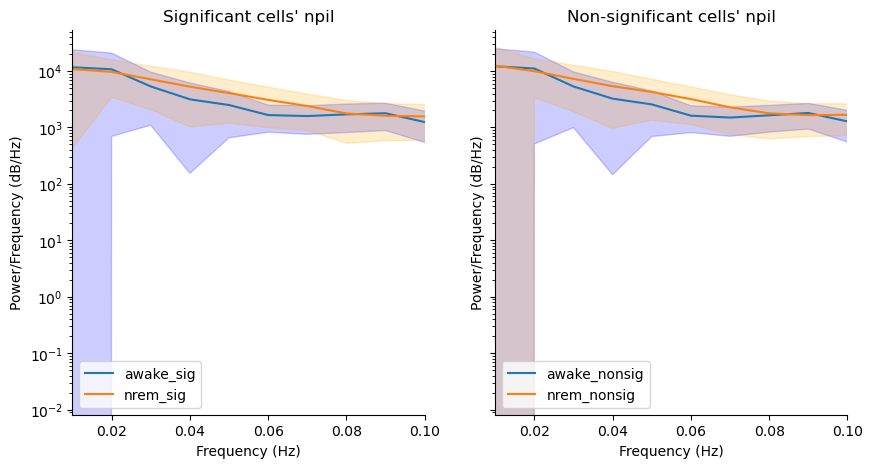

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

nl.spectral_density_plot(
    npil_psd_df,
    ["awake_sig", "nrem_sig"],
    ax=ax[0],
    labels={"title": "Significant cells' npil"},
)
nl.spectral_density_plot(
    npil_psd_df,
    ["awake_nonsig", "nrem_nonsig"],
    ax=ax[1],
    labels={"title": "Non-significant cells' npil"},
)